# Final project COM-309: Qiskit

We start by importing the libraries. If you do not have Qiskit installed on your computer yet, please refer to the previous notebook on dynamics of spin in magnetic fields or to [the official documentation](https://docs.quantum.ibm.com/guides/install-qiskit).

In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt

### Preliminaries

Let's define the Bell states. In Qiskit, the pure states are represented by [`qiskit.quantum_info.Statevector`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Statevector). You can use either NumPy arrays or [`Statevector.from_label()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Statevector#from_label) method to convert bitstrings to vectors.

In [2]:
from qiskit.quantum_info import Statevector

# Bell states (in vector form)
b_00 = Statevector([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)])  
b_01 = Statevector([0, 1/np.sqrt(2), 1/np.sqrt(2), 0])  
b_10 = Statevector([1/np.sqrt(2), 0, 0, -1/np.sqrt(2)]) 
b_11 = Statevector([0, 1/np.sqrt(2), -1/np.sqrt(2), 0])

### Question 1: Implement the circuit to construct Werner states.

We remind the quantum circuit that construct a Werner state. 

<img src="werner_circuit.png" alt="drawing" width="500"/>

To implement $G$ we will use the following generic architecture: 

<img src="gate_g.png" alt="drawing" width="500"/>

where the gates $R_y$ are rotation around the $Y$ axis.
This circuit allows to contruct any two qubit states. In our case, the angles $\alpha$, $\beta$ and $\gamma$ will depend on $w$ such that $G(w)\ket{00} = \sqrt{\frac{1-w}{4}}\left(\ket{00} + \ket{01}+\ket{10}\right) + \sqrt{\frac{1+3w}{4}} \ket{11}$.

We give you the function that precompute $\alpha$, $\beta$ and $\gamma$ for a given $w$. 


In [3]:
def angle_werner(w):
    p00, p01, p10  = (np.sqrt((1 - w) / 4), ) * 3
    p11 = np.sqrt((1 + 3 * w) / 4)
    alpha = np.arcsin(2 * (p00 * p11 - p01 * p10))
    c_alpha, s_alpha = np.cos(alpha / 2), np.sin(alpha / 2)

    if abs(c_alpha) <= 1e-10:
        beta = 2 * np.arctan2(p00, p10)
        return alpha, beta, 0
    
    A = 1 / np.cos(alpha) * np.array([[c_alpha * p00 - s_alpha * p11, c_alpha * p01 + s_alpha * p10],
                                      [s_alpha * p01 + c_alpha * p10, c_alpha * p11 - s_alpha * p00]])

    x = np.array([1, 1])
    b = (A @ A.T @ x / np.linalg.norm(A @ A.T @ x)).reshape(-1, 1)
    c = (A.T @ A @ x / np.linalg.norm(A.T @ A @ x)).reshape(-1, 1)
    beta = 2 * np.arctan2(b[1,0], b[0,0])
    if np.allclose(b @ c.T, A):
        gamma = 2 * np.arctan2(c[1,0], c[0,0])
    else:
        gamma = 2 * np.arctan2(-c[1,0], -c[0,0])
    
    return alpha, beta, gamma

With this function, implement the complete circuit and plot it. You should obtain a circuit similar to the first figure.

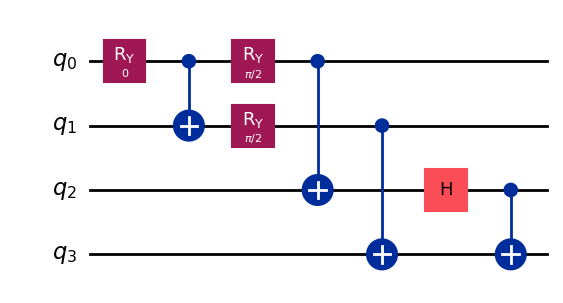

In [ ]:
from qiskit import QuantumCircuit

## This is used to create a new gate G(w) that prepares the Werner state
# def werner_state_preparation(w):
#     alpha, beta, gamma = angle_werner(w)
#     #G(w):
#     gw_circuit = QuantumCircuit(2, name="G(w)")
#     gw_circuit.ry(alpha, 0)
#     gw_circuit.cx(0, 1)
#     gw_circuit.ry(beta, 0)
#     gw_circuit.ry(gamma, 1)
#     gw_gate = gw_circuit.to_gate()

#     #Circuit
#     circ = QuantumCircuit(4)
#     circ.append(gw_gate, [0, 1]) 
#     circ.cx(0, 2)
#     circ.cx(1, 3)
#     circ.h(2)
#     circ.cx(2, 3)

#     return circ

##This is the circuit with G(w) developped :
def werner_state_preparation(w):
    alpha, beta, gamma = angle_werner(w)
    circ = QuantumCircuit(4)
    circ.ry(alpha, 0)  
    circ.cx(0, 1)
    circ.ry(beta, 0)        
    circ.ry(gamma, 1) 
    circ.cx(0, 2)
    circ.cx(1, 3)
    circ.h(2)
    circ.cx(2,3)
    return circ
    

w = 0
qc = werner_state_preparation(w)
qc.draw('mpl')

Compute $\rho_W (w)$ by taking the partial trace over the first two qubits. 

In [ ]:
from qiskit.quantum_info import DensityMatrix, partial_trace

def density_matrix_werner(w):
    circ= werner_state_preparation(w)
    density_matrix = DensityMatrix(circ)
    rho_W = partial_trace(density_matrix, [0, 1])
    return rho_W
    

You can test your circuit using the following cell.

In [6]:
w = 0.5
rho = density_matrix_werner(w)
rho_ref = (1 - w) / 4 * DensityMatrix(np.eye(4)) + w * DensityMatrix(b_11)
print(f"The output is correct for w = {w}: ", np.allclose(rho, rho_ref))

The output is correct for w = 0.5:  True


### Question 2:  Apply the Peres criterion to the Werner state for $w \in [0,1]$. For which $w$ is $\rho_W (w)$ separable ?

We start by implementing the partial transpose. You can use either Numpy operations or [`DensityMatrix.partial_transpose()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.DensityMatrix#partial_transpose) method.

In [7]:
def partial_transpose(rho):
    return rho.partial_transpose(qargs=[0]) ##2 works also

You can check your code with the following cell.

In [8]:
A = DensityMatrix(np.arange(16).reshape(4, 4))
A_pt_ref = DensityMatrix(np.array([
    [0, 4, 2, 6],
    [1, 5, 3, 7],
    [8, 12, 10, 14],
    [9, 13,11,15]
]))
print(f"The output is correct:", np.allclose(partial_transpose(A), A_pt_ref))
print(A.data.real)
print(partial_transpose(A).data.real)



The output is correct: True
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]
[[ 0.  4.  2.  6.]
 [ 1.  5.  3.  7.]
 [ 8. 12. 10. 14.]
 [ 9. 13. 11. 15.]]


Complete the following cell to compute the smallest eigenvalue of $(I_{C}\otimes T_{D})\rho_W (w)$.

In [9]:
def peres_criterion(w):
    rho_W = density_matrix_werner(w)
    ITrho_W = partial_transpose(rho_W)
    eigenvalues = np.linalg.eigvalsh(ITrho_W)
    return np.min(eigenvalues)

print(peres_criterion(0.5))

-0.12499999999999986


Plot the smallest eigenvalue of $\rho_W (w)$ for $w \in [0,1]$. You should observe that $\rho_W (w)$ is entangled for $w > w_{limit}$. What is the value of $w_{limit}$?

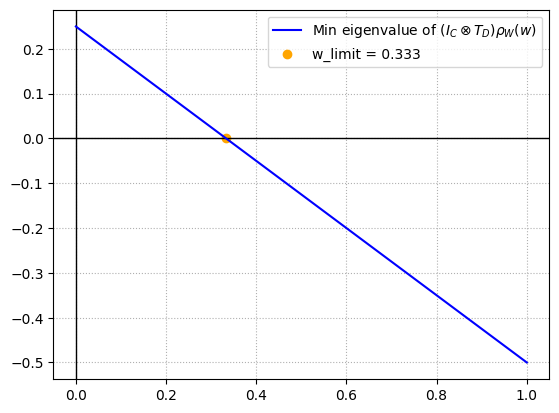

In [10]:
w = np.linspace(0,1,100)
y1 = np.array([peres_criterion(x) for x in w])

w_limit = np.argmin(np.abs(y1))

plt.axhline(y=0, lw=1, color='k')
plt.axvline(x=0, lw=1, color='k')
plt.grid(ls=":")
plt.plot(w,y1,color="blue", label=r"Min eigenvalue of $(I_{C}\otimes T_{D})\rho_W (w)$")
plt.scatter(w[w_limit], y1[w_limit],color="orange",label=f"w_limit = {np.round(w[w_limit],3)}")
plt.legend()
plt.show()

### Question 3: Run the circuit to measure $\chi(w)$ for $w \in [0, 1]$ and draw plot of this dependence. 

First, we have to define the observable $\mathcal{B}$ that we would like to measure.

In Qiskit, [`qiskit.quantum_info.SparsePauliOp`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp) is the most important class to represent a quantum operator, as it is the format used for observables to measure. This class represents an operator as a linear combination of Pauli strings. You can perform operations on its instances such as addition, subtraction, scalar multiplication, dot product ([`.dot()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp#dot) or `@`) and tensor product ([`.tensor()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp#tensor) or `^` (note that `^` is performed after `+`)).

Your task is to implement $\mathcal{B}$, represented by variable `Bell_op`.

*Note:* by [Qiskit conventions](https://docs.quantum.ibm.com/guides/bit-ordering#strings), bitstrings $q_{n - 1} q_{n - 2} \dots q_{0}$ start with $(n - 1)$-th qubit and end with $0$-th one. This applies to Pauli strings as well: "XZ" applies "Z" to the first qubit, and "X" to the second one, not vice versa as one might have expected.

In [4]:
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.quantum_info import Operator

X = SparsePauliOp("X")
Z = SparsePauliOp("Z")
I = SparsePauliOp("I").tensor(SparsePauliOp("I"))

A0 = X
A1 = Z
B0 = -1/np.sqrt(2) * X + 1/np.sqrt(2) * Z
B1 = -1/np.sqrt(2) * X - 1/np.sqrt(2) * Z


bell_op = B0.tensor(A0) + B1.tensor(A0) - B0.tensor(A1) + B1.tensor(A1)
Bell_op_adapted = bell_op.tensor(I)



#Example to understand the tensor product
print(Bell_op_adapted)
matrix01 = Operator(A0.tensor(A1)).data
print(matrix01)

SparsePauliOp(['XXII', 'ZXII', 'XXII', 'ZXII', 'XZII', 'ZZII', 'XZII', 'ZZII'],
              coeffs=[-0.70710678+0.j,  0.70710678+0.j, -0.70710678+0.j, -0.70710678+0.j,
  0.70710678+0.j, -0.70710678+0.j, -0.70710678+0.j, -0.70710678+0.j])
[[ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]]


Now, as our circuit also has 2 environment qubits, we will measure $I_2 \otimes I_2 \otimes \mathcal{B}$ instead of $\mathcal{B}$. Adapt your previous operator for this and store the result in `Bell_op_circuit`.

In [12]:
Bell_op_circuit = Bell_op_adapted

Below, we instantiate perfect simulator:

In [13]:
from qiskit.primitives import StatevectorEstimator

estimator_perfect = StatevectorEstimator()

Prepare circuits for the given values of $w$ and store them in `qcs_werner`.

In [14]:
qcs_werner = [werner_state_preparation(x) for x in w]

Finally, we run the measurements by using [`StatevectorEstimator.run()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorEstimator#run). The `.run` method takes as an argument an iterable of tuples `(circuit, observable)` &mdash; fill it in. Then, we call [`.result()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.PrimitiveJob#result) method of the returned object to obtain iterable of results.

In [15]:
inputs = [(circ, Bell_op_circuit) for circ in qcs_werner]
result_perfect = estimator_perfect.run(inputs).result()

To obtain the measured values themselves, call methods sequence `.data.evs` of each of the [`PubResult`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.PubResult) object.

In [16]:
from qiskit.primitives import PubResult
chi_perfect = np.array([pub_result.data.evs for pub_result in result_perfect])


Plot $\chi(w)$ against $w$; compare it to the CHSH validity bound and Tsirelson's bound.

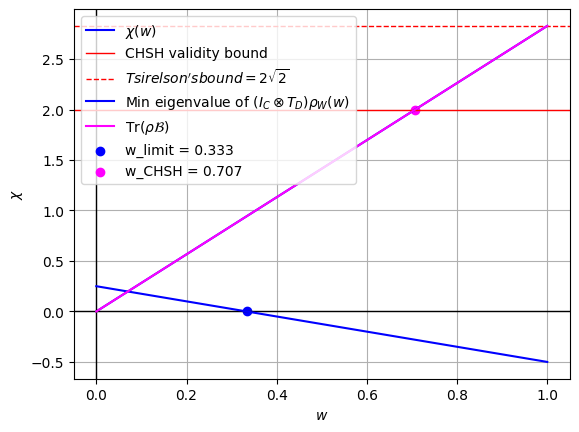

χ(w=0): -4.710277376051325e-16
χ(w=1): 2.8284271247461894


In [17]:
y1 = np.array([peres_criterion(x) for x in w])
w_limit = np.argmin(np.abs(y1))
w_CHSH = np.argmin(np.abs(chi_perfect-2))

plt.plot(w, chi_perfect, color ="blue", label='$\\chi(w)$')
plt.axhline(y=0, lw=1, color='k')
plt.axvline(x=0, lw=1, color='k')
plt.axhline(y=2, lw=1, color='r', label='CHSH validity bound')
plt.axhline(y=2 * np.sqrt(2), lw=1, color='r', ls='--', label=r"$Tsirelson's bound=2\sqrt{2}$")
plt.grid()
plt.plot(w,y1,color='b',label=r"Min eigenvalue of $(I_{C}\otimes T_{D})\rho_W (w)$")
plt.plot(w, chi_perfect,color="fuchsia",label=r'Tr($\rho \mathcal{B}$)')
plt.scatter(w[w_limit], y1[w_limit],color='b',label=f"w_limit = {np.round(w[w_limit],3)}")
plt.scatter(w[w_CHSH], chi_perfect[w_CHSH],color="fuchsia",label=f"w_CHSH = {np.round(w[w_CHSH],3)}")
plt.xlabel('$w$')
plt.ylabel('$\\chi$')
plt.legend()
plt.show()

chi_w_0 = chi_perfect[0]
print(f"\u03C7(w=0): {chi_w_0}")


chi_w_1 = chi_perfect[-1] 
print(f"\u03C7(w=1): {chi_w_1}")


## Bonus question


Now, we are going to make measurements on a real quantum computer &#x2728;	

First, make sure `qiskit_ibm_runtime` is installed. If not, run `pip install qiskit-ibm-runtime` in your Python environment. Then, set up to use IBM Quantum Platform according to [guide](https://docs.quantum.ibm.com/guides/setup-channel#set-up-to-use-ibm-quantum-platform).



In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

If everything is configured properly, you now should be able to access real IBM QPUs. With [free plan](https://docs.quantum.ibm.com/guides/instances#open-plan), you have up to **10 minutes per month** of quantum time.

To see which of the instances are available, you can either check [Compute resources webpage](https://quantum.ibm.com/services/resources) or call a method [QiskitRuntimeService.backends](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService#backends).

Let's choose a backend. Below, we are using the least busy one, but you can pre-set it if you want.

In [19]:
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_sherbrooke')>


Now, we would like to send the circuits from before to a QPU and measure the observable. However, before this, we have to adapt them to the architecture of the chosen computer, as it might have a specific topology and a limited number of implemented basis gates. For example, for our backend, those are:

In [20]:
backend.configuration().basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

This process is called transpilation,  you can read more about it [here](https://docs.quantum.ibm.com/transpile) if you wish, but the simplest way to perform it is to call [qiskit.compiler.transpile](https://docs.quantum.ibm.com/api/qiskit/compiler#transpile) &mdash; it takes a circuit and a backend as arguments. Perform transpilation for each of the circuits  in `qcs_werner_qpu`.

In [21]:
from qiskit.compiler import transpile
isa_qcs_werner = [transpile(qc, backend=backend, optimization_level=3) for qc in qcs_werner]

You can see below how the circuit changes. Notice how we use option `idle_wires=False` in visualization function: you probably don't want a picture with all 127 wires!

Depth of circuit for w = 0.242: 39


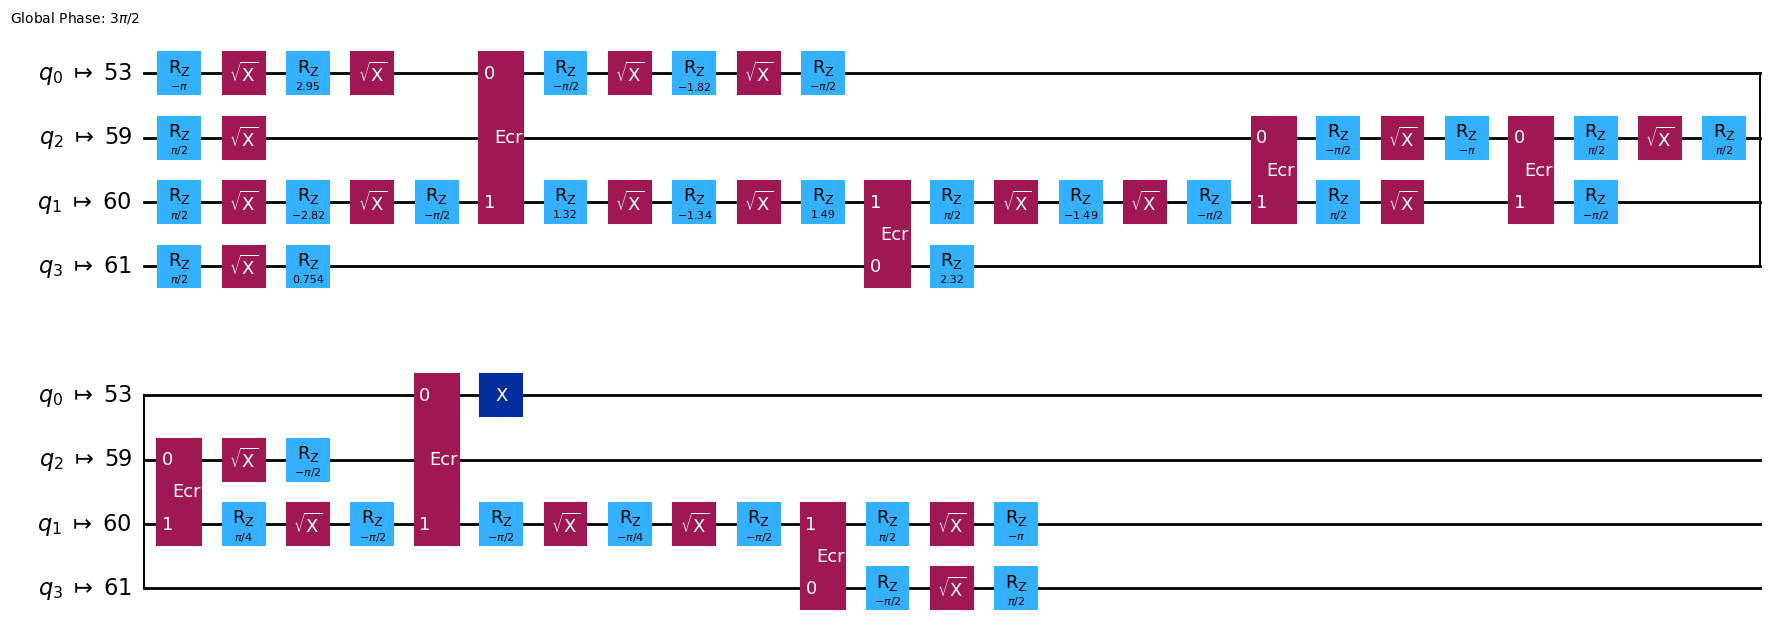

In [22]:
i_example = 24
isa_qc_example = isa_qcs_werner[i_example]
print(f'Depth of circuit for w = {w[i_example]:.3f}: {isa_qc_example.depth()}')
isa_qc_example.draw('mpl', idle_wires=False)

We also have to adapt an observable to the updated circuit, it can be done like this:

In [23]:
Bell_op_circuit.apply_layout(isa_qc_example.layout)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ

Do this for each of the circuits; note that different circuits may have different layouts, such as active wires.

In [24]:
isa_Bell_op = [Bell_op_circuit.apply_layout(circuit.layout) for circuit in isa_qcs_werner]

Now, we instatiate [`Estimator`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) interface which allows us to use the backend for obserables measurement.

In [25]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator_true = Estimator(mode=backend)

Finally, we can submit the circuit, which is done in the same fashion as before. Fill in the argument with the transpiled circuits and corresponding observables. The returned object is, in fact, a  [`RuntimeJob`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.RuntimeJobV2) interface representing the quantum program launch on the remote instance.

The real circuit, unlike the perfect simulator, estimates $\chi$ through actual measurements rather than the mathematical operations. The number of them, i.e. number of shots, is indirectly specified through `precision` argument &mdash; it is of order $O(\frac{1}{\sqrt{\mathrm{n\_shots}}})$. The lower its value, the higher the number of shots used.  Default is usually set to $0.015625 = \frac{1}{\sqrt{4096}}$, i.e. 4096 shots ([source to claim](https://github.com/Qiskit/qiskit-ibm-runtime/blob/639f3071833cef46443adf83eba7ea925b00257c/qiskit_ibm_runtime/options/estimator_options.py#L39)).
 
*Note:* it might take some time, usually hours before your job is launched. However, the process of running the circuits itself should be pretty quick (i.e. < 1 minute total for the circuits together and precision equal to 0.0625).

In [26]:
inputs = [(circ, obs) for circ, obs in zip(isa_qcs_werner, isa_Bell_op)]
job = estimator_true.run(inputs, precision=0.0625)

If you lose the instance of the job (for example, by shutting down the notebook kernel), no worries &mdash; you can retrieve the job by accessing dashboard https://quantum.ibm.com/workloads, taking its ID as an argument to the method below:

In [27]:
job = service.job("cxf04csgcckg008s8ej0")

As before, obtain the result:

In [28]:
chi_estimated = np.array([pub_result.data.evs for pub_result in job.result()])

Compare it to the reference result:

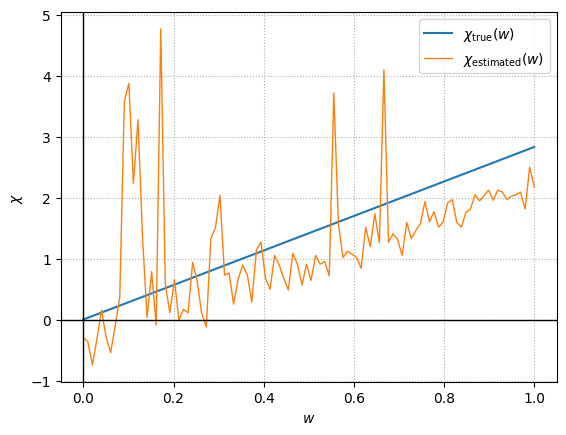

In [29]:
plt.plot(w, chi_perfect, label='$\\chi_{\\mathrm{true}}(w)$')
plt.plot(w, chi_estimated, label='$\\chi_{\\mathrm{estimated}}(w)$', lw=1.)

plt.axhline(y=0, lw=1, color='k')
plt.axvline(x=0, lw=1, color='k')

plt.grid(ls=":")
plt.xlabel('$w$')
plt.ylabel('$\\chi$')
plt.legend()
plt.show()